# A Quantitative Evaluation of the European Commission´s Fiscal Governance Proposal

- This notebook reproduces results of the Bruegel Working Paper "A Quantitative Evaluation of the European Commission´s Fiscal Governance Proposal" by Zsolt Darvas, Lennard Welslau, and Jeromin Zettelmeyer (2023). 
- For details on the methodology see Annex II, "Methodology and code for implementing the European Commission´s DSA in the context of the economic governance review".
- For comments and suggestions please contact lennard.welslau[at]bruegel[dot]org.

In [1]:
# Import libraries and modules
import numpy as np
import pandas as pd
pd.options.display.float_format = "{:,.3f}".format
import datetime
import time
import os
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import seaborn as sns
sns.set_style('whitegrid')

# Load Conduit font and set as default
import matplotlib.font_manager as fm
prop = fm.FontProperties(fname='Conduit ITC Regular.otf', size=12)

# Import DSA model class and stochastic subclass
from EcDsaModelClass import EcDsaModel
from EcStochasticModelClass import EcStochasticModel

# Set autoreleoad
%load_ext autoreload
%autoreload 2

## Example Cases
This section introduces some of the functionalities of the EcDsaModelClass and the EcStochasticModelClass.

### Deterministic Model Class

Initialize model with country ISO code and adjustment period length. For deterministic projections the parent class "EcDsaModel" can be used.

In [2]:
bel_dsa_model = EcDsaModel(country='BEL', adjustment_period=4)

Project the debt ratio forward, assuming linear adjustment to a structural primary balance target using the "project" method. \
To project the model under specific scenario assumptions, pass the scenario name as a string. Deterministic scenarios are "main_adjustment", "adverse_r_g", "financial_stress", and "lower_spb".

In [3]:
bel_dsa_model.project(spb_target=1, scenario='main_adjustment')

Show the resulting debt ratio and primary balance path using the "df" method. \
The "df" method takes strings of the model variables or a dictionary with model variables and desired column names as input argument and returns a pandas dataframe.

In [4]:
output_var_dict = {'d': 'Debt ratio', 'spb_bcoa': 'Ageing-cost adjusted structural primary balance', 'pb': 'Primary balance', 'ob':'Overall balance'}
output_df = bel_dsa_model.df(output_var_dict)
output_df.head(10)

,,Debt ratio,Ageing-cost adjusted structural primary balance,Primary balance,Overall balance
t,y,,,,
0,2022,105.129,-2.655,-2.365,NaN
1,2023,105.972,-3.138,-3.254,-4.690
2,2024,107.323,-2.504,-2.753,-4.725
3,2025,108.240,-1.628,-2.098,-4.364
4,2026,108.709,-0.752,-1.460,-3.963
5,2027,108.415,0.124,-0.688,-3.384
6,2028,107.338,1.000,0.187,-2.658
7,2029,105.511,1.000,0.426,-2.504
8,2030,103.854,1.000,0.656,-2.345


The "find_spb_deterministic" method finds the structural primary balance path so that specified criteria are met given scenario assumptions.

In [5]:
bel_dsa_model.find_spb_deterministic(scenario='adverse_r_g', criterion='debt_decline')

1.8309999999998334

The model is upodated automatically to the optimal SPB and we can plot the resulting debt ratio projection using the "df" method and build-in plotting function.

<Axes: title={'center': 'Debt ratio projection Belgium'}, xlabel='(t, Year)', ylabel='Debt ratio'>

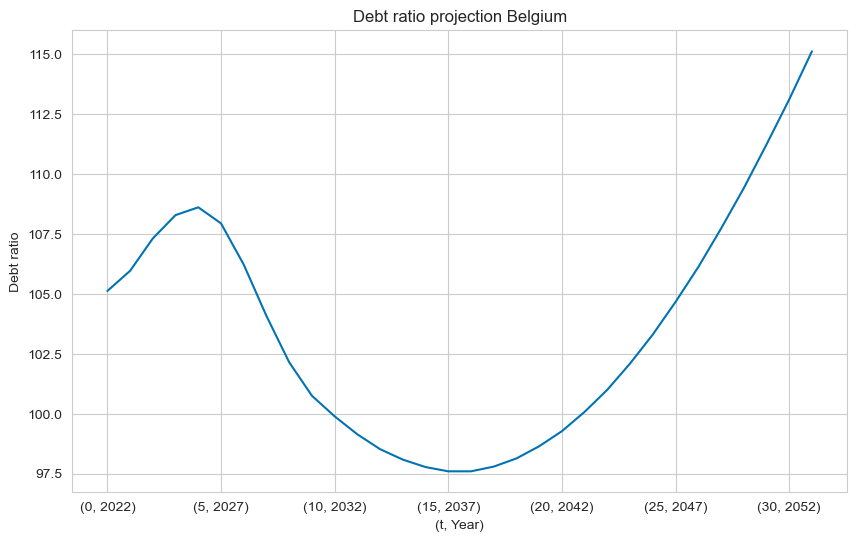

In [6]:
bel_dsa_model.df('d').plot(title='Debt ratio projection Belgium', ylabel='Debt ratio', xlabel='(t, Year)', legend=False, figsize=(10, 6))

### Stochastic Model Class

The Stochastic Model Class is a subclass of the EcDsaModels and inherits all its functionalities. It is initiated analogously.

In [7]:
esp_dsa_stochastic_model = EcStochasticModel(country='ESP', adjustment_period=7)

After projecting the debt path, the "simulate" method simulates N projections based on shocks to growth, interest rate, exchange rate, and primary balance.

In [8]:
esp_dsa_stochastic_model.project()
esp_dsa_stochastic_model.simulate(N=10000)

The "find_spb_stochastic" method optimizes for the primary balance path that ensures no more than 30% of simulated debt ratio paths are increasing.

In [9]:
esp_dsa_stochastic_model.find_spb_stochastic(prob_target=0.3)

1.9089062701384263

The "fanchart" method plots the percentiles of the simulated distribution of the debt ratio.

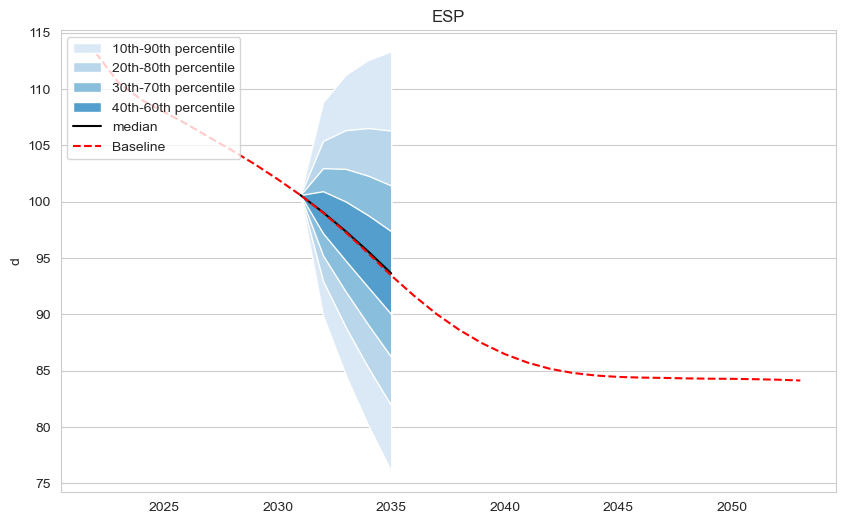

In [10]:
esp_dsa_stochastic_model.fanchart(variable='d')

The "find_spb_deficit" method optimizes for the structural primary balance that ensures a decline in the debt ratio after reaching a deficit below 3%.

In [11]:
esp_dsa_stochastic_model = EcStochasticModel(country='ESP', adjustment_period=7)
spb_deficit_safeguard = esp_dsa_stochastic_model.find_spb_deficit()
spb_deficit_safeguard

Deficit periods: 3
spb_initial_adjustment_step 0.5
ESP spb_target: {'main_adjustment': 1.178799999999832, 'lower_spb': 1.674299999999833, 'financial_stress': 1.178999999999832, 'adverse_r_g': 1.9873999999998329, 'deficit_reduction': 1.4565999999998325, 'debt_safeguard': 0.4214999999998323, 'stochastic': 1.9041147229116717}


1.9873999999998329

In [12]:
output_df = esp_dsa_stochastic_model.df(output_var_dict)
output_df['Annual adjustment'] = output_df['Ageing-cost adjusted structural primary balance'].diff()
output_df.head(10)

,,Debt ratio,Ageing-cost adjusted structural primary balance,Primary balance,Overall balance,Annual adjustment
t,y,,,,,
0,2022,113.216,-1.571,-2.425,NaN,NaN
1,2023,110.581,-1.229,-1.589,-3.907,0.342
2,2024,109.073,-0.767,-0.885,-3.317,0.462
3,2025,108.012,-0.267,-0.571,-3.264,0.500
4,2026,106.844,0.233,-0.183,-3.080,0.500
5,2027,105.445,0.733,0.279,-2.782,0.500
6,2028,103.876,1.047,0.674,-2.515,0.314
7,2029,102.298,1.360,1.042,-2.249,0.314
8,2030,100.714,1.674,1.381,-1.989,0.314


The "find_deficit_prob" method builds on the stochastic model to calculate the probabilites of an excessive deficit in each year of the adjustment period. \
It requires the specification of an adjustment path by passing aa structural primary balance target, and optionally, the number and step size of initial periods under deficit procedure. 

Text(0.5, 1.0, 'Probability of deficit during 7-year adjustment Spain')

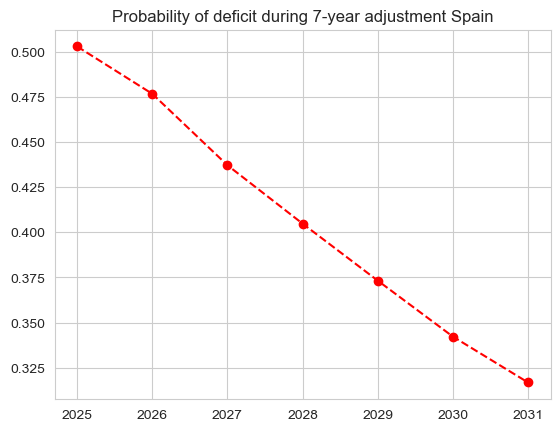

In [13]:
prob_deficit = esp_dsa_stochastic_model.find_deficit_prob(spb_target=1.9473, spb_initial_adjustment_period=3, spb_initial_adjustment_step=0.5)
plt.plot(np.arange(2025, 2032), prob_deficit, marker='o', linestyle='--', color='red')
plt.title('Probability of deficit during 7-year adjustment Spain')

Finally, the "find_spb_post_debt_safeguard" is a method that finds the strucutral primary balance needed to both satsify the debt safeguard over the first four years and satisfies all other criteria over the next three years. This method is needed to test 7-year adjustment cases in which the average adjustment over the first four years does not satisfy the debt safeguard.

In [14]:
bel_stochastic_model = EcStochasticModel(country='BEL', adjustment_period=7)
bel_stochastic_model.find_spb_post_debt_safeguard()

BEL spb target: {'main_adjustment': 1.0827999999998326, 'lower_spb': 1.5846999999998328, 'financial_stress': 1.0829999999998325, 'adverse_r_g': 1.9015999999998334, 'deficit_reduction': 1.4055999999998325, 'stochastic': 1.658093466916434}


1.9015999999998334

In [15]:
output_df = bel_stochastic_model.df(output_var_dict)
output_df['Annual adjustment'] = output_df['Ageing-cost adjusted structural primary balance'].diff()
output_df.head(10)

,,Debt ratio,Ageing-cost adjusted structural primary balance,Primary balance,Overall balance,Annual adjustment
t,y,,,,,
0,2022,105.129,-2.655,-2.365,NaN,NaN
1,2023,105.972,-3.138,-3.254,-4.690,-0.484
2,2024,107.323,-2.504,-2.753,-4.725,0.635
3,2025,108.241,-1.625,-2.096,-4.362,0.879
4,2026,108.708,-0.746,-1.457,-3.960,0.879
5,2027,108.409,0.133,-0.682,-3.378,0.879
6,2028,107.323,1.011,0.196,-2.649,0.879
7,2029,105.398,1.308,0.760,-2.176,0.297
8,2030,103.314,1.605,1.235,-1.765,0.297


## Define variables and functions

In [16]:
today = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M')

eu_code_dict = {
    'AUT': 'Austria',
    'BEL': 'Belgium',
    'CYP': 'Cyprus',
    'CZE': 'Czech Republic',
    'DEU': 'Germany',
    'DNK': 'Denmark',
    'ESP': 'Spain',
    'FIN': 'Finland',
    'FRA': 'France',
    'GRC': 'Greece',
    'HRV': 'Croatia',
    'HUN': 'Hungary',
    'IRL': 'Ireland',
    'ITA': 'Italy',
    'NLD': 'Netherlands',
    'POL': 'Poland',
    'PRT': 'Portugal',
    'ROU': 'Romania',
    'SVK': 'Slovakia',
    'SVN': 'Slovenia',
    'SWE': 'Sweden',
    'BGR': 'Bulgaria',
    'MLT': 'Malta',
    'LTU': 'Lithuania',
    'LVA': 'Latvia'
}

eu_codes = list(eu_code_dict.keys())

var_list = [
    'rg', # real GDP growth
    'rg_pot', # potential real GDP growth
    'ng',  # nominal GDP growth
    'output_gap', # output gap
    'pi', # inflation
    'rgdp_pot', # potential real GDP
    'rgdp', # real GDP
    'ngdp', # nominal GDP
    'i_st', # short-term interest rate
    'i_lt', # long-term interest rate
    'iir_lt', # implicit long-term interest rate
    'iir', # implicit interest rate
    'sf', # stock flow adjustment
    'ageing_cost', # ageing cost
    'ageing_component', # ageing component of primary balance
    'cyclical_component', # cyclical component of primary balance
    'spb_bcoa', # ageing-cost adjusted structural primary balance
    'pb', # primary balance
    'pb_cyclical_adj', # cyclically adjusted primary balance
    'pb_cyclical_ageing_adj', # cyclically and ageing-cost adjusted primary balance
    'ob', # overall balance
    'd', # debt ratio
    'D', # debt level
    'D_lt_inst', # long-term instirutional debt level 
    'D_st', # short-term debt level
    'D_lt', # long-term debt level
    'amortization', # amortization
    'amortization_lt', # long-term amortization
    'amortization_lt_inst' # long-term institutional amortization
    ]

# Set path
if not os.path.exists(f'../output/{today}'):
    os.makedirs(f'../output/{today}')
if not os.path.exists(f'../output/{today}/fancharts'):
    os.makedirs(f'../output/{today}/fancharts') 
if not os.path.exists(f'../output/{today}/results_charts'):
    os.makedirs(f'../output/{today}/results_charts')       
output_path = f'../output/{today}'

In [17]:
# Define function to run deterministic criteria scenarios
def run_deterministic_scenario(country, adjustment_period, scenario=None, criterion=None, scenario_name='scenario'):
    try:
        dsa = EcDsaModel(country=country, adjustment_period=adjustment_period)
        if scenario_name == 'nfpc':
            dsa.project() # No optimization needed if no fiscal policy change
        else:
            dsa.find_spb_deterministic(scenario=scenario, criterion=criterion)
        df = dsa.df(var_list)
        results_dict[country][adjustment_period][scenario_name] = {}
        results_dict[country][adjustment_period][scenario_name]['df'] = df
        results_dict[country][adjustment_period][scenario_name]['spbstar'] = dsa.spb_bcoa[dsa.adjustment_end]
        results_dict[country][adjustment_period][scenario_name]['ob'] = dsa.ob[dsa.adjustment_end]
        results_dict[country][adjustment_period][scenario_name]['d_T+A+10'] = dsa.d[dsa.adjustment_end+10]
        results_dict[country][adjustment_period][scenario_name]['high_deficit'] = np.any(dsa.ob[dsa.adjustment_start:dsa.adjustment_end+1] < -3)
        results_dict[country][adjustment_period][scenario_name]['annual_adjustment'] = dsa.spb_bcoa[dsa.adjustment_start] - dsa.spb_bcoa[dsa.adjustment_start-1]
        results_dict[country][adjustment_period][scenario_name]['debt_safeguard_satisfied'] = dsa.d[dsa.adjustment_start-1] > dsa.d[dsa.adjustment_start+3]

    except:
        pass

## Run scenario analysis

This section calcualtes optimal primary balances and addiitonal model variables under different scenarios. These variables are saved in a results dictionary, which is subsequently used to assess the applicability of additional safeguards, select the binding scenario, and prepare result figures.

In [18]:
# Initialize results dictionary
results_dict = {}
for country in eu_codes:
    results_dict[country] = {}
    for adjustment_period in [4, 7]:
        results_dict[country][adjustment_period] = {}

### Find optimal structural primary balances for deterministic scenarios

In [19]:
## Deterministic scenario loop
start_time = time.time()
total_countries = len(eu_codes)
for counter, country in enumerate(eu_codes):
    counter += 1
    elapsed_time = time.time() - start_time
    estimated_remaining_time = round((elapsed_time / counter) * (total_countries - counter) / 60, 1)
    print(f'{counter} of {total_countries} - Estimated remaining time: {estimated_remaining_time} minutes', end='\r')

    for adjustment_period in [4, 7]:
        
        # NFPC scenario
        if adjustment_period == 4:
            run_deterministic_scenario(
                country=country, 
                adjustment_period=4, 
                scenario=None, 
                criterion=None,
                scenario_name='nfpc'
                )

        # Main_adjustment and adverse scenarios
        for scenario in ['main_adjustment', 'adverse_r_g', 'financial_stress', 'lower_spb']:
            run_deterministic_scenario(
                country=country, 
                adjustment_period=adjustment_period, 
                scenario=scenario, 
                criterion='debt_decline', 
                scenario_name=scenario
                )

        # Main_adjustment with deficit/expenditure/debt criteria
        for criterion in ['deficit_reduction', 'expenditure_safeguard', 'debt_safeguard']:
            if criterion == 'debt_safeguard' and adjustment_period == 7:
                continue
            else:
                run_deterministic_scenario(
                    country=country, 
                    adjustment_period=adjustment_period, 
                    scenario='main_adjustment', 
                    criterion=criterion, 
                    scenario_name=criterion
                    )

    # Set nfpc and debt safeguard 7 year results equal to 4 year results
    for scenario in ['nfpc', 'debt_safeguard']:
        if scenario in results_dict[country][4].keys():
            results_dict[country][7][scenario] = {}
            for key in results_dict[country][4][scenario].keys():
                results_dict[country][7][scenario][key] = results_dict[country][4][scenario][key]

### Find optimal structural primary balances for stochastic scenarios

In [20]:
## Stochastic scenario loop
start_time = time.time()
for counter, country in enumerate(eu_codes):
    
    counter += 1
    elapsed_time = time.time() - start_time
    estimated_remaining_time = round((elapsed_time / counter) * (total_countries - counter) / 60, 1)
    print(f'{counter} of {total_countries} - Estimated remaining time: {estimated_remaining_time} minutes', end='\r')

    for adjustment_period in [4, 7]:
        try:
            dsa = EcStochasticModel(country=country, adjustment_period=adjustment_period)
            dsa.find_spb_stochastic()
            df = dsa.df(var_list)
            dsa.fanchart(save_as=f'{output_path}/fancharts/fanchart_{country}_{adjustment_period}_{today}.jpeg', save_df=True, show=False)
            results_dict[country][adjustment_period]['stochastic'] = {}
            results_dict[country][adjustment_period]['stochastic']['df'] = df
            results_dict[country][adjustment_period]['stochastic']['df_fanchart'] = dsa.df_fanchart
            results_dict[country][adjustment_period]['stochastic']['spbstar'] = dsa.spb_bcoa[dsa.adjustment_end]
            results_dict[country][adjustment_period]['stochastic']['ob'] = dsa.ob[dsa.adjustment_end]
            results_dict[country][adjustment_period]['stochastic']['d_T+A+10'] = dsa.d[dsa.adjustment_end+10]
            results_dict[country][adjustment_period]['stochastic']['high_deficit'] = np.any(dsa.ob[dsa.adjustment_start:dsa.adjustment_end+1] < -3)
            results_dict[country][adjustment_period]['stochastic']['annual_adjustment'] = dsa.spb_bcoa[dsa.adjustment_start] - dsa.spb_bcoa[dsa.adjustment_start-1]
            results_dict[country][adjustment_period]['stochastic']['debt_safeguard_satisfied'] = dsa.d[dsa.adjustment_start-1] > dsa.d[dsa.adjustment_start+3]
        except:
            pass

### Find optimal structural primary balances after a binding debt safeguard in the 7-year scenario

In [21]:
## Deficit safeguard scenario loop
for country, adjustment_period_dict in results_dict.items():
    for adjustment_period, scenario_dict in adjustment_period_dict.items():
        if adjustment_period == 4:
            continue

        # Find max spbstar for adjustment period
        max_spbstar = - np.inf
        max_spbstar_key = None
        for scenario, variable_dict in scenario_dict.items():
            if scenario in [
                'main_adjustment', 'adverse_r_g', 'financial_stress', 'lower_spb',  'deficit_reduction', 'debt_safeguard', 'expenditure_safeguard', 'stochastic'
                ] and 'spbstar' in variable_dict.keys():
                spbstar_value = variable_dict['spbstar']
                if spbstar_value > max_spbstar:
                    max_spbstar = spbstar_value
                    max_spbstar_key = (country, adjustment_period, max_spbstar, scenario)
        
        # Check if debt_safeguard satisfied in toughest scenario
        if max_spbstar_key is not None:
            country, adjustment_period, max_spbstar, scenario = max_spbstar_key
            debt_safeguard_satisfied = results_dict[country][adjustment_period][scenario]['debt_safeguard_satisfied']
            if not debt_safeguard_satisfied or scenario == 'debt_safeguard':

                # Find optimal spbstar with deficit procedure
                print('Calculating optimal spb for', country, adjustment_period, max_spbstar, 'from', scenario)
                dsa = EcStochasticModel(country=country, adjustment_period=adjustment_period)
                try:
                    dsa.find_spb_post_debt_safeguard()
                except:
                    continue
                df = dsa.df(var_list)
                results_dict[country][adjustment_period]['post_debt_safeguard'] = {}
                results_dict[country][adjustment_period]['post_debt_safeguard']['df'] = df
                results_dict[country][adjustment_period]['post_debt_safeguard']['spbstar'] = dsa.spb_bcoa[dsa.adjustment_end]
                results_dict[country][adjustment_period]['post_debt_safeguard']['ob'] = dsa.ob[dsa.adjustment_end]
                results_dict[country][adjustment_period]['post_debt_safeguard']['d_T+A+10'] = dsa.d[dsa.adjustment_end+10]
                results_dict[country][adjustment_period]['post_debt_safeguard']['high_deficit'] = np.any(dsa.ob[dsa.adjustment_start:dsa.adjustment_end+1] < -3)
                results_dict[country][adjustment_period]['post_debt_safeguard']['annual_adjustment'] = dsa.spb_bcoa[dsa.adjustment_start] - dsa.spb_bcoa[dsa.adjustment_start-1]
                results_dict[country][adjustment_period]['post_debt_safeguard']['spb_initial_adjustment_period'] = dsa.spb_initial_adjustment_period
                results_dict[country][adjustment_period]['post_debt_safeguard']['spb_initial_adjustment_step'] = dsa.spb_initial_adjustment_step

Calculating optimal spb for BEL 7 1.9263999999998331 from adverse_r_g
BEL spb target: {'main_adjustment': 1.0827999999998326, 'lower_spb': 1.5846999999998328, 'financial_stress': 1.0829999999998325, 'adverse_r_g': 1.9015999999998334, 'deficit_reduction': 1.4055999999998325, 'stochastic': 1.6668774259545145}
Calculating optimal spb for FRA 7 2.335999999999817 from debt_safeguard
FRA spb target: {'main_adjustment': 0.35589999999983174, 'lower_spb': 0.31919999999983134, 'financial_stress': 0.35589999999983174, 'adverse_r_g': 0.896999999999832, 'deficit_reduction': 0.3671999999998316, 'stochastic': 0.7771444819085059}
Calculating optimal spb for NLD 7 0.26189999999983193 from deficit_reduction
Calculating optimal spb for ROU 7 1.207999999999832 from deficit_reduction
ROU spb target: {'main_adjustment': -0.1790000000001679, 'lower_spb': 0.18689999999983148, 'financial_stress': -0.1790000000001679, 'adverse_r_g': 0.15719999999983142, 'deficit_reduction': 1.149299999999832, 'stochastic': 0.48

### Find optimal structural primary balances for binding deficit safeguard scenarios

In [22]:
## Deficit safeguard scenario loop
for country, adjustment_period_dict in results_dict.items():
    for adjustment_period, scenario_dict in adjustment_period_dict.items():

        # Find max spbstar for adjustment period
        max_spbstar = - np.inf
        max_spbstar_key = None
        for scenario, variable_dict in scenario_dict.items():
            if scenario in [
                'main_adjustment', 'adverse_r_g', 'financial_stress', 'lower_spb',  'deficit_reduction', 'debt_safeguard', 'expenditure_safeguard', 'stochastic'
                ] and 'spbstar' in variable_dict.keys():
                spbstar_value = variable_dict['spbstar']
                if spbstar_value > max_spbstar:
                    max_spbstar = spbstar_value
                    max_spbstar_key = (country, adjustment_period, max_spbstar, scenario)
        
        # Check if toughest scenario has excessive deficit and low adjustment
        if max_spbstar_key is not None:
            country, adjustment_period, max_spbstar, scenario = max_spbstar_key
            high_deficit = results_dict[country][adjustment_period][scenario]['high_deficit']
            annual_adjustment = results_dict[country][adjustment_period][scenario]['annual_adjustment']
            if high_deficit and (annual_adjustment < 0.5):

                # Find optimal spbstar with deficit procedure
                print('Calculating optimal spb for', country, adjustment_period, max_spbstar, 'from', scenario)
                dsa = EcStochasticModel(country=country, adjustment_period=adjustment_period)
                dsa.find_spb_deficit()
                df = dsa.df(var_list)

                # Save results
                results_dict[country][adjustment_period]['deficit_safeguard'] = {}
                results_dict[country][adjustment_period]['deficit_safeguard']['df'] = df
                results_dict[country][adjustment_period]['deficit_safeguard']['spbstar'] = dsa.spb_bcoa[dsa.adjustment_end]
                results_dict[country][adjustment_period]['deficit_safeguard']['ob'] = dsa.ob[dsa.adjustment_end]
                results_dict[country][adjustment_period]['deficit_safeguard']['d_T+A+10'] = dsa.d[dsa.adjustment_end+10]
                results_dict[country][adjustment_period]['deficit_safeguard']['high_deficit'] = np.any(dsa.ob[dsa.adjustment_start:dsa.adjustment_end+11] < -3)
                results_dict[country][adjustment_period]['deficit_safeguard']['annual_adjustment'] = dsa.spb_bcoa[dsa.adjustment_start] - dsa.spb_bcoa[dsa.adjustment_start-1]
                results_dict[country][adjustment_period]['deficit_safeguard']['spb_initial_adjustment_period'] = dsa.spb_initial_adjustment_period
                results_dict[country][adjustment_period]['deficit_safeguard']['spb_initial_adjustment_step'] = dsa.spb_initial_adjustment_step

Calculating optimal spb for ESP 7 1.9994999999998324 from adverse_r_g
Deficit periods: 3
spb_initial_adjustment_step 0.5
ESP spb_target: {'main_adjustment': 1.178799999999832, 'lower_spb': 1.674299999999833, 'financial_stress': 1.178999999999832, 'adverse_r_g': 1.9873999999998329, 'deficit_reduction': 1.4565999999998325, 'debt_safeguard': 0.4214999999998323, 'stochastic': 1.9111079703669545}
Calculating optimal spb for HUN 7 3.8264171803378786 from stochastic
Deficit periods: 4
spb_initial_adjustment_step 0.5
HUN spb_target: {'main_adjustment': 2.6442999999998067, 'lower_spb': 2.9976999999998064, 'financial_stress': 2.6441999999998065, 'adverse_r_g': 3.045599999999801, 'deficit_reduction': 2.9622999999997957, 'debt_safeguard': 1.5918999999998331, 'stochastic': 3.812889778461773}
Calculating optimal spb for ITA 7 2.6828999999998024 from deficit_reduction
Deficit periods: 6
spb_initial_adjustment_step 0.5
ITA spb_target: {'main_adjustment': 1.693899999999833, 'lower_spb': 1.9206999999998

### Run scenarios with baseline assumptions and binding structural primary balance

In [23]:
## Main adjusmtent scenario loop for binding SPB target
for country, adjustment_period_dict in results_dict.items():
    for adjustment_period, scenario_dict in adjustment_period_dict.items():
        max_spbstar = - np.inf
        max_spbstar_key = None
        spbstar_frontloaded_key = None
        for scenario, variable_dict in scenario_dict.items():
            if scenario in [
                'main_adjustment', 'adverse_r_g', 'financial_stress', 'lower_spb', 'stochastic', 'deficit_reduction', 'debt_safeguard', 'expenditure_safeguard'
                ] and 'spbstar' in variable_dict.keys():
                spbstar_value = variable_dict['spbstar']
                if spbstar_value > max_spbstar:
                    max_spbstar = spbstar_value
                    spb_initial_adjustment_period = 0
                    spb_initial_adjustment_step = 0
                    max_spbstar_key = (country, adjustment_period, spb_initial_adjustment_period, spb_initial_adjustment_step, max_spbstar, scenario)
            elif scenario in [
                'post_debt_safeguard', 'deficit_safeguard'
                ] and 'spbstar' in variable_dict.keys():
                spbstar_frontloaded = variable_dict['spbstar']
                spb_initial_adjustment_period = variable_dict['spb_initial_adjustment_period']
                spb_initial_adjustment_step = variable_dict['spb_initial_adjustment_step']
                spbstar_frontloaded_key = (country, adjustment_period, spb_initial_adjustment_period, spb_initial_adjustment_step, spbstar_frontloaded, scenario)

        
        # Run baseline scenario with max spbstar or frontloaded spbstar if defined
        if max_spbstar_key is not None and spbstar_frontloaded_key is None:
            country, adjustment_period, spb_initial_adjustment_period, spb_initial_adjustment_step, spbstar, scenario = max_spbstar_key
        
        elif spbstar_frontloaded_key is not None:
            country, adjustment_period, spb_initial_adjustment_period, spb_initial_adjustment_step, spbstar, scenario = spbstar_frontloaded_key

        dsa = EcDsaModel(country=country, adjustment_period=adjustment_period)
        dsa.project(spb_target=spbstar, spb_initial_adjustment_period=spb_initial_adjustment_period, spb_initial_adjustment_step=spb_initial_adjustment_step)
        df = dsa.df(var_list)

        results_dict[country][adjustment_period]['baseline_binding_spbstar'] = {}
        results_dict[country][adjustment_period]['baseline_binding_spbstar']['df'] = df
        results_dict[country][adjustment_period]['baseline_binding_spbstar']['spbstar'] = dsa.spb_bcoa[dsa.adjustment_end]
        results_dict[country][adjustment_period]['baseline_binding_spbstar']['ob'] = dsa.ob[dsa.adjustment_end]
        results_dict[country][adjustment_period]['baseline_binding_spbstar']['d_T+A+10'] = dsa.d[dsa.adjustment_end+10]
        results_dict[country][adjustment_period]['baseline_binding_spbstar']['high_deficit'] = np.any(dsa.ob[dsa.adjustment_start:dsa.adjustment_end+10] < -3)
        results_dict[country][adjustment_period]['baseline_binding_spbstar']['annual_adjustment'] = dsa.spb_bcoa[dsa.adjustment_start] - dsa.spb_bcoa[dsa.adjustment_start-1]
        results_dict[country][adjustment_period]['baseline_binding_spbstar']['spb_initial_adjustment_period'] = dsa.spb_initial_adjustment_period
        results_dict[country][adjustment_period]['baseline_binding_spbstar']['spb_initial_adjustment_step'] = dsa.spb_initial_adjustment_step

### Find the probability of excessive deficit during the adjustment period

In [24]:
# Initialize deficit_prob_dict
deficit_prob_dict = {}

# Get df of binding scenario
for country, adjustment_period_dict in results_dict.items():
    deficit_prob_dict[country] = {}
    for adjustment_period, scenario_dict in adjustment_period_dict.items():
        deficit_prob_dict[country][adjustment_period] = {}
        
        # Set deficit parameters to baseline
        spbstar = scenario_dict['baseline_binding_spbstar']['spbstar']
        spb_initial_adjustment_period = scenario_dict['baseline_binding_spbstar']['spb_initial_adjustment_period']
        spb_initial_adjustment_step = scenario_dict['baseline_binding_spbstar']['spb_initial_adjustment_step']

        # Find probability of excessive deficit
        try:
            dsa = EcStochasticModel(country=country, adjustment_period=adjustment_period)
            dsa.find_deficit_prob(spb_target=spbstar, spb_initial_adjustment_period=spb_initial_adjustment_period, spb_initial_adjustment_step=spb_initial_adjustment_step)
            deficit_prob_dict[country][adjustment_period]['deficit_prob'] = dsa.prob_deficit
        except:
            deficit_prob_dict[country][adjustment_period]['deficit_prob'] = np.full(adjustment_period, np.nan)
            

## Save results to output folder

In [25]:
# Save deficit probability results
columns_4 = ['Country'] + [str(2025 + i) for i in range(4)]
columns_7 = ['Country'] + [str(2025 + i) for i in range(7)]

data_4 = []
data_7 = []

for country, values in deficit_prob_dict.items():
    row_4 = [country] + list(values.get(4, {'deficit_prob': []})['deficit_prob'])
    row_7 = [country] + list(values.get(7, {'deficit_prob': []})['deficit_prob'])
    data_4.append(row_4)
    data_7.append(row_7)

df_4 = pd.DataFrame(data_4, columns=columns_4)
df_7 = pd.DataFrame(data_7, columns=columns_7)

# Create an Excel writer
with pd.ExcelWriter(f'{output_path}/ec_dsa_results_prob_deficit_{today}.xlsx') as writer:
    df_4.to_excel(writer, sheet_name='4-year', index=False)
    df_7.to_excel(writer, sheet_name='7-year', index=False)


In [26]:
# Convert results_dict dataframes to an Excel file, name sheets according to country-adjustment_period-scenario
with pd.ExcelWriter(f'{output_path}/ec_dsa_results_timeseries_{today}.xlsx') as writer:
        for country in results_dict.keys():
            try:
                for adjustment_period in results_dict[country].keys():
                    for scenario in results_dict[country][adjustment_period].keys():
                        sheet_name = f'{country}_{adjustment_period}_{scenario}'[:31] # limit sheet_name length to 31 characters
                        df = results_dict[country][adjustment_period][scenario]['df']
                        df.to_excel(writer, sheet_name=sheet_name)
            except:
                continue

In [27]:
# Save end of adjustment period 'spbstar'
try:
    df_spb = pd.DataFrame()
    for country in results_dict.keys():
            for adjustment_period in results_dict[country].keys():
                for scenario in results_dict[country][adjustment_period].keys():
                    spbstar_value = results_dict[country][adjustment_period][scenario]['spbstar']
                    df = pd.DataFrame(columns=['country', 'adjustment_period', 'scenario', 'spbstar'])
                    df.loc[0] = [country, adjustment_period, scenario, spbstar_value]
                    df_spb = pd.concat([df_spb, df])
except:
    raise
    
df_spb.reset_index(drop=True, inplace=True)
df_spb = df_spb.pivot(index=['country', 'adjustment_period'], columns='scenario', values='spbstar').reset_index()
df_spb['binding_scenario'] = df_spb[[
    'main_adjustment', 'adverse_r_g', 'financial_stress', 'lower_spb', 'stochastic', 'deficit_reduction', 'debt_safeguard', 'post_debt_safeguard', 'deficit_safeguard', 'expenditure_safeguard'
    ]].idxmax(axis=1)

df_spb.loc[df_spb['deficit_safeguard'].notnull(), 'binding_scenario'] = 'deficit_safeguard'
df_spb.loc[df_spb['post_debt_safeguard'].notnull(), 'binding_scenario'] = 'post_debt_safeguard'

df_spb['binding_spb'] = df_spb['baseline_binding_spbstar']

df_spb['binding_spb'] = df_spb['baseline_binding_spbstar']
df_spb['frontloaded_safeguard'] = df_spb['deficit_safeguard'].fillna(df_spb['post_debt_safeguard'])
df_spb.drop(columns=['deficit_safeguard', 'post_debt_safeguard'], inplace=True)


var_order = ['country', 'adjustment_period', 'nfpc', 'main_adjustment', 'adverse_r_g', 'financial_stress', 'lower_spb', 'deficit_reduction', 'stochastic', 'debt_safeguard', 'frontloaded_safeguard', 'expenditure_safeguard', 'binding_scenario', 'binding_spb']
df_spb = df_spb[var_order]
df_spb.to_excel(f'{output_path}/ec_dsa_results_spbstar_{today}.xlsx', index=False)

In [28]:
# Convert results_dict fanchart dataframes to an Excel file, name sheets according to country-adjustment_period
with pd.ExcelWriter(f'{output_path}/ec_dsa_results_fancharts_{today}.xlsx') as writer:
        for country in results_dict.keys():
            try:
                for adjustment_period in results_dict[country].keys():
                    sheet_name = f'{country}_{adjustment_period}_fanchart'[:31] # limit sheet name length to 31 characters
                    df_fanchart = results_dict[country][adjustment_period]['stochastic']['df_fanchart']
                    df_fanchart.to_excel(writer, sheet_name=sheet_name)
            except:
                pass

## Figure 2

In [29]:
# Initialize bel_chart_dict
bel_chart_dict = {}

for scenario in ['main_adjustment', 'baseline_binding_spbstar']:
    bel_chart_dict[scenario] = {}
    df = results_dict['BEL'][4][scenario]['df'].reset_index()
    df_rg = results_dict['BEL'][4]['adverse_r_g']['df'].reset_index()

    # Set deficit parameters to baseline
    spbstar = results_dict['BEL'][4][scenario]['spbstar']

    # Create df for chart a)
    df_interest_ageing_growth = df[['y', 'iir', 'ageing_cost', 'ng']].rename(columns={'y': 'year', 'iir': 'Implicit interest rate', 'ng': 'Nominal GDP growth', 'ageing_cost':'Ageing costs'})
    df_interest_ageing_growth = df_interest_ageing_growth[['year', 'Ageing costs', 'Implicit interest rate', 'Nominal GDP growth']]
    if scenario == 'baseline_binding_spbstar':
        df_rg = results_dict['BEL'][4]['adverse_r_g']['df'][['iir', 'ng']].reset_index().rename(columns={'iir': 'Implicit interest rate - adverse r-g', 'ng': 'Nominal GDP growth - adverse r-g'})
        df_interest_ageing_growth['Implicit interest rate - adverse r-g'] = df_rg['Implicit interest rate - adverse r-g']
        df_interest_ageing_growth['Nominal GDP growth - adverse r-g'] = df_rg['Nominal GDP growth - adverse r-g']
        df_interest_ageing_growth = df_interest_ageing_growth[['year', 'Ageing costs', 'Implicit interest rate', 'Nominal GDP growth', 'Implicit interest rate - adverse r-g', 'Nominal GDP growth - adverse r-g']]
    bel_chart_dict[scenario]['df_interest_ageing_growth'] = df_interest_ageing_growth.set_index('year').loc[:2050]

    # Create df for chart b)
    df_budget_balance = df[['y', 'spb_bcoa', 'pb', 'ob', 'ageing_component']].rename(columns={'y': 'year', 'spb_bcoa': 'Age-adjusted structural primary balance', 'pb': 'Primary balance', 'ob': 'Overall balance'})
    df_budget_balance['Structural primary balance'] = df_budget_balance['Age-adjusted structural primary balance'] + df_budget_balance['ageing_component'] 
    df_budget_balance.drop('ageing_component', axis=1, inplace=True)
    
    # Use .loc to modify the DataFrame without SettingWithCopyWarning
    df_budget_balance.loc[:1+4, 'Structural primary balance'] = df_budget_balance['Age-adjusted structural primary balance'].iloc[:2+4]

    df_budget_balance = df_budget_balance[['year', 'Age-adjusted structural primary balance', 'Structural primary balance', 'Primary balance', 'Overall balance']]
    bel_chart_dict[scenario]['df_budget_balance'] = df_budget_balance.set_index('year').loc[:2050]

    # Run fanchart for chart c)
    dsa = EcStochasticModel(country='BEL', adjustment_period=4)
    dsa.project(spb_target=spbstar)
    dsa.simulate()
    dsa.fanchart(save_df=True, show=False)
    df_fanchart = dsa.df_fanchart
    df_fanchart.loc[2+4+6:, 'p10':'p90'] = np.nan
    bel_chart_dict[scenario]['df_fanchart'] = df_fanchart.set_index('year').loc[:2050]


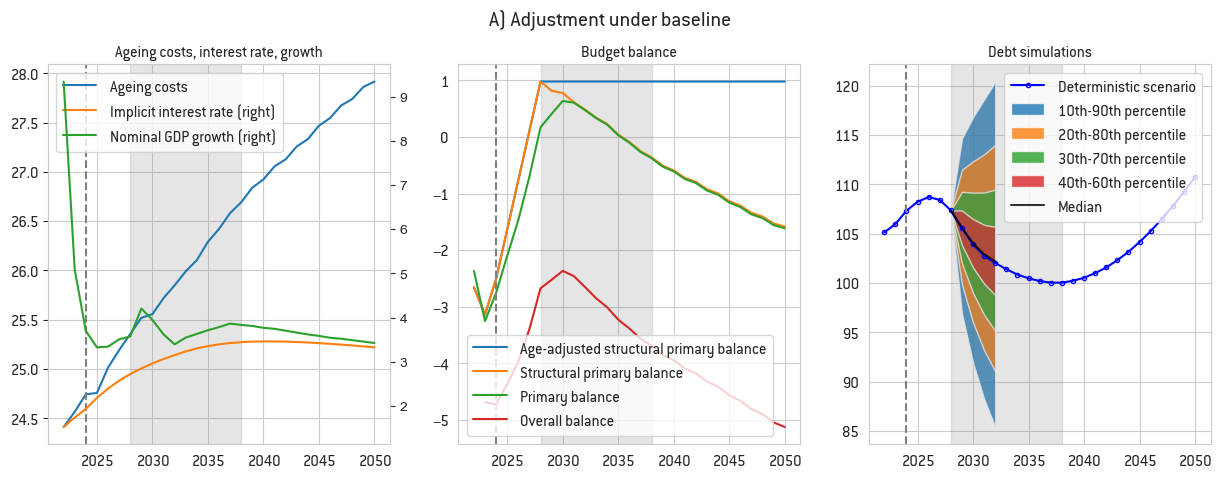

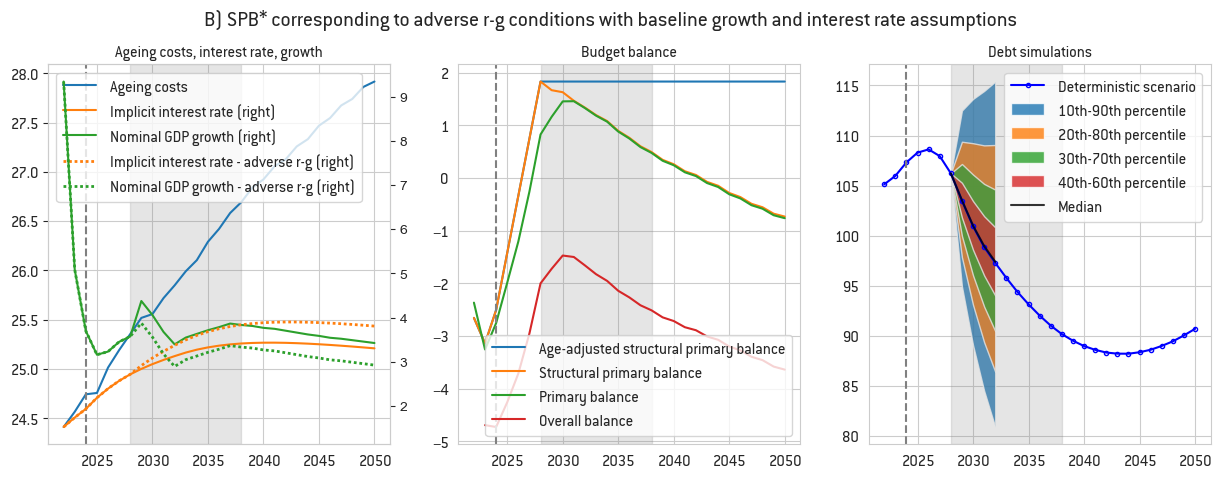

In [30]:
# Set color pallette
sns.set_palette(sns.color_palette('tab10'))
subtitle_size = 14 
for scenario in bel_chart_dict.keys():
    if scenario == 'main_adjustment':
        figure_title = 'A) Adjustment under baseline'
    elif scenario == 'baseline_binding_spbstar':
        figure_title = 'B) SPB* corresponding to adverse r-g conditions with baseline growth and interest rate assumptions'
    
    # Make 1, 3 sublot with df_interest_ageing_growth, df_budget_balance, df_fanchart
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle(figure_title, fontsize=16, fontproperties=prop)

    ## Plot df_interest_ageing_growth
    axs[0].set_title('Ageing costs, interest rate, growth', fontsize=subtitle_size, fontproperties=prop)
    df_interest_ageing_growth = bel_chart_dict[scenario]['df_interest_ageing_growth']
    colors = sns.color_palette("tab10")
    axs[0].plot(df_interest_ageing_growth.index, df_interest_ageing_growth['Ageing costs'], label='Ageing costs', color=colors[0])
    axs1 = axs[0].twinx()  # Create a twin Axes for the secondary y-axis
    axs1.plot(df_interest_ageing_growth.index, df_interest_ageing_growth['Implicit interest rate'], label='Implicit interest rate (right)', color=colors[1])
    axs1.plot(df_interest_ageing_growth.index, df_interest_ageing_growth['Nominal GDP growth'], label='Nominal GDP growth (right)', color=colors[2])

    if scenario == 'baseline_binding_spbstar':
        axs1.plot(df_interest_ageing_growth.index, df_interest_ageing_growth['Implicit interest rate - adverse r-g'], label='Implicit interest rate - adverse r-g (right)', ls=(0,(1,1)), lw=2, color=colors[1])
        axs1.plot(df_interest_ageing_growth.index, df_interest_ageing_growth['Nominal GDP growth - adverse r-g'], label='Nominal GDP growth - adverse r-g (right)', ls=(0,(1,1)), lw=2, color=colors[2])
    axs1.grid(None)

    lines, labels = axs[0].get_legend_handles_labels()
    lines1, labels1 = axs1.get_legend_handles_labels()
    axs[0].legend(lines + lines1, labels + labels1, loc='upper left', prop=prop)


    axs[0].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))



    # Plot df_budget_balance
    axs[1].set_title('Budget balance', fontsize = subtitle_size, fontproperties=prop)
    df_budget_balance = bel_chart_dict[scenario]['df_budget_balance']
    df_budget_balance.plot(ax=axs[1])
    axs[1].legend(loc='best', prop=prop)

    # Plot df_fanchart
    df_fanchart = bel_chart_dict[scenario]['df_fanchart']

    # plot, fill between p10 & p90, p20 & p80, p40 & p60
    # plot p50
    # plot baseline
    axs[2].set_title('Debt simulations', fontsize = subtitle_size, fontproperties=prop)
    axs[2].plot(df_fanchart.index, df_fanchart['baseline'], color='blue', marker='o', markerfacecolor='none', markersize=3, label='Deterministic scenario')
    try:
        axs[2].fill_between(df_fanchart.index, df_fanchart['p10'], df_fanchart['p90'], label='10th-90th percentile', alpha=0.8)
        axs[2].fill_between(df_fanchart.index, df_fanchart['p20'], df_fanchart['p80'], label='20th-80th percentile', alpha=0.8)
        axs[2].fill_between(df_fanchart.index, df_fanchart['p30'], df_fanchart['p70'], label='30th-70th percentile', alpha=0.8)
        axs[2].fill_between(df_fanchart.index, df_fanchart['p40'], df_fanchart['p60'], label='40th-60th percentile', alpha=0.8)
        axs[2].plot(df_fanchart.index, df_fanchart['p50'], color='black', alpha=0.8, label='Median')
    except:
        pass
    axs[2].legend(loc='upper right', prop=prop)

    # add grey fill for 10 year post adustment and delete x-axis label
    for i in range(3):
        axs[i].axvspan(df_fanchart.index[2+4], df_fanchart.index[12+4], alpha=0.2, color='grey')
        axs[i].axvline(df_fanchart.index[2], color='grey', linestyle='--', lw=1.5)
        axs[i].set_xlabel('')
    
    for i in range(3):
        tick_labels = axs[i].get_xticklabels()
        tick_labels.extend(axs[i].get_yticklabels())
        for tick in tick_labels:
            tick.set_fontproperties(prop)

    fig.subplots_adjust(top=0.87)

    # Export to jpeg
    plt.savefig(f'{output_path}/results_charts/fig2_BEL_4_{scenario}.jpeg', dpi=300, bbox_inches='tight')
    plt.savefig(f'{output_path}/results_charts/fig2_BEL_4_{scenario}.svg', format='svg', bbox_inches='tight')


## Figure 3

In [31]:
# Initialize fra_chart_dict
df = results_dict['FRA'][7]['baseline_binding_spbstar']['df'].reset_index()

# Create df for chart b)
df_budget_balance = df[['y', 'spb_bcoa', 'pb', 'ob', 'ageing_component']].rename(columns={'y': 'year', 'spb_bcoa': 'Age-adjusted structural primary balance', 'pb': 'Primary balance', 'ob': 'Overall balance'})
df_budget_balance['Structural primary balance'] = df_budget_balance['Age-adjusted structural primary balance'] + df_budget_balance['ageing_component'] 
df_budget_balance.drop('ageing_component', axis=1, inplace=True)

# Use .loc to modify the DataFrame without SettingWithCopyWarning
df_budget_balance.loc[:1+7, 'Structural primary balance'] = df_budget_balance['Age-adjusted structural primary balance'].iloc[:2+7]
df_budget_balance = df_budget_balance[['year', 'Age-adjusted structural primary balance', 'Structural primary balance', 'Primary balance', 'Overall balance']].set_index('year').loc[:2050]

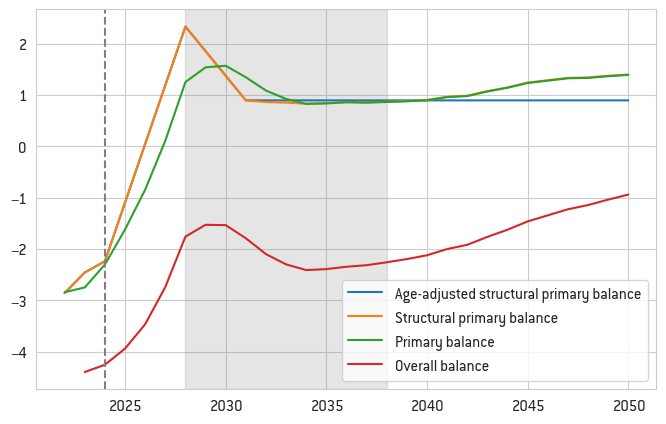

In [32]:
# Set color pallette
sns.set_palette(sns.color_palette('tab10'))
subtitle_size = 14 

fig, ax = plt.subplots(1, 1, figsize=(8, 5))

# Plot df_budget_balance
df_budget_balance.plot(ax=ax)
ax.legend(loc='best', prop=prop)

# add grey fill for 10 year post adustment and delete x-axis label
ax.axvspan(df_fanchart.index[2+4], df_fanchart.index[12+4], alpha=0.2, color='grey')
ax.axvline(df_fanchart.index[2], color='grey', linestyle='--', lw=1.5)
ax.set_xlabel('')

tick_labels = ax.get_xticklabels()
tick_labels.extend(ax.get_yticklabels())
for tick in tick_labels:
    tick.set_fontproperties(prop)

fig.subplots_adjust(top=0.87)

# Export to jpeg
plt.savefig(f'{output_path}/results_charts/fig3_FRA_7_{scenario}.jpeg', dpi=300, bbox_inches='tight')
plt.savefig(f'{output_path}/results_charts/fig3_FRA_7_{scenario}.svg', format='svg', bbox_inches='tight')


## Annex figures

In [33]:
# Initialize chart_dict
chart_dict = {}

# 1) get df of binding scenario
for country, adjustment_period_dict in results_dict.items():
    chart_dict[country] = {}
    for adjustment_period, scenario_dict in adjustment_period_dict.items():
        chart_dict[country][adjustment_period] = {}
        
        try:
            # Safe df for baseline binding scenario
            df = results_dict[country][adjustment_period]['baseline_binding_spbstar']['df'].reset_index()
        except:
            continue

        # Set deficit parameters to baseline
        spbstar = results_dict[country][adjustment_period]['baseline_binding_spbstar']['spbstar']
        spb_initial_adjustment_period = results_dict[country][adjustment_period]['baseline_binding_spbstar']['spb_initial_adjustment_period']
        spb_initial_adjustment_step = results_dict[country][adjustment_period]['baseline_binding_spbstar']['spb_initial_adjustment_step']

        # Create df for chart a)
        df_interest_ageing_growth = df[['y', 'iir', 'ageing_cost', 'ng']].rename(columns={'y': 'year', 'iir': 'Implicit interest rate', 'ng': 'Nominal GDP growth', 'ageing_cost':'Ageing costs'})
        df_interest_ageing_growth = df_interest_ageing_growth[['year', 'Ageing costs', 'Implicit interest rate', 'Nominal GDP growth']]
        chart_dict[country][adjustment_period]['df_interest_ageing_growth'] = df_interest_ageing_growth.set_index('year').loc[:2050]

        # Create df for chart b)
        df_budget_balance = df[['y', 'spb_bcoa', 'pb', 'ob', 'ageing_component']].rename(columns={'y': 'year', 'spb_bcoa': 'Age-adjusted structural primary balance', 'pb': 'Primary balance', 'ob': 'Overall balance'})
        df_budget_balance['Structural primary balance'] = df_budget_balance['Age-adjusted structural primary balance'] + df_budget_balance['ageing_component'] 
        df_budget_balance.drop('ageing_component', axis=1, inplace=True)
        df_budget_balance.loc[:1+adjustment_period, 'Structural primary balance'] = df_budget_balance['Age-adjusted structural primary balance'].iloc[:2+adjustment_period]
        
        df_budget_balance = df_budget_balance[['year', 'Age-adjusted structural primary balance', 'Structural primary balance', 'Primary balance', 'Overall balance']]
        chart_dict[country][adjustment_period]['df_budget_balance'] = df_budget_balance.set_index('year').loc[:2050]

        # Run fanchart for chart c)
        try:
            if country == 'BGR':
                raise Exception('BGR has no viable fanchart because of restricted sample period')
            dsa = EcStochasticModel(country=country, adjustment_period=adjustment_period)
            dsa.project(spb_target=spbstar, spb_initial_adjustment_period=spb_initial_adjustment_period, spb_initial_adjustment_step=spb_initial_adjustment_step)
            dsa.simulate()
            dsa.fanchart(save_df=True, show=False)
            df_fanchart = dsa.df_fanchart
            df_fanchart.loc[2+adjustment_period+6:, 'p10':'p90'] = np.nan
            chart_dict[country][adjustment_period]['df_fanchart'] = df_fanchart.set_index('year').loc[:2050]
        except:
            df_fanchart = pd.DataFrame(columns=['year', 'baseline', 'p10', 'p20', 'p30', 'p40', 'p50', 'p60', 'p70', 'p80', 'p90'])
            df_fanchart['year'] = df['y']
            df_fanchart['baseline'] = df['d']
            chart_dict[country][adjustment_period]['df_fanchart'] = df_fanchart.set_index('year').loc[:2050]

In [ ]:
# Set color pallette
sns.set_palette(sns.color_palette('tab10'))
subtitle_size = 14 
for country in chart_dict.keys():
    for adjustment_period in chart_dict[country].keys():
        
        try:
            # Make 1, 3 sublot with df_interest_ageing_growth, df_budget_balance, df_fanchart
            fig, axs = plt.subplots(1, 3, figsize=(15, 5))
            fig.suptitle(f'{eu_code_dict[country]}: {adjustment_period}-year scenario', fontsize=16, fontproperties=prop)

            # Plot df_interest_ageing_growth
            axs[0].set_title('Ageing costs, interest rate, growth', fontsize = subtitle_size, fontproperties=prop)
            df_interest_ageing_growth = chart_dict[country][adjustment_period]['df_interest_ageing_growth']
            df_interest_ageing_growth.plot(ax=axs[0], secondary_y=['Implicit interest rate', 'Nominal GDP growth'])
            axs[0].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
            lines = axs[0].get_lines() + axs[0].right_ax.get_lines()
            axs[0].legend(lines, [l.get_label() for l in lines], loc='best', prop=prop)

            # Plot df_budget_balance
            axs[1].set_title('Budget balance', fontsize = subtitle_size, fontproperties=prop)
            df_budget_balance = chart_dict[country][adjustment_period]['df_budget_balance']
            df_budget_balance.plot(ax=axs[1])
            axs[1].legend(loc='best', prop=prop)

            # Plot df_fanchart
            df_fanchart = chart_dict[country][adjustment_period]['df_fanchart']
            axs[2].set_title('Debt simulations', fontsize = subtitle_size, fontproperties=prop)
            axs[2].plot(df_fanchart.index, df_fanchart['baseline'], color='blue', marker='o', markerfacecolor='none', markersize=3, label='Deterministic scenario')
            try:
                axs[2].fill_between(df_fanchart.index, df_fanchart['p10'], df_fanchart['p90'], label='10th-90th percentile', alpha=0.8)
                axs[2].fill_between(df_fanchart.index, df_fanchart['p20'], df_fanchart['p80'], label='20th-80th percentile', alpha=0.8)
                axs[2].fill_between(df_fanchart.index, df_fanchart['p30'], df_fanchart['p70'], label='30th-70th percentile', alpha=0.8)
                axs[2].fill_between(df_fanchart.index, df_fanchart['p40'], df_fanchart['p60'], label='40th-60th percentile', alpha=0.8)
                axs[2].plot(df_fanchart.index, df_fanchart['p50'], color='black', alpha=0.8, label='Median')
            except:
                pass
            axs[2].legend(loc='best', prop=prop)

            # add grey fill for 10 year post adustment and delete x-axis label
            for i in range(3):
                axs[i].axvspan(df_fanchart.index[2+adjustment_period], df_fanchart.index[12+adjustment_period], alpha=0.2, color='grey')
                axs[i].axvline(df_fanchart.index[2], color='grey', linestyle='--', lw=1.5)
                axs[i].set_xlabel('')
                    
            for i in range(3):
                tick_labels = axs[i].get_xticklabels()
                tick_labels.extend(axs[i].get_yticklabels())
                for tick in tick_labels:
                    tick.set_fontproperties(prop)

            # Increase space between subplots and heading
            fig.subplots_adjust(top=0.87)

            # Export to jpeg
            plt.savefig(f'{output_path}/results_charts/{country}_{adjustment_period}.jpeg', dpi=300, bbox_inches='tight')
            plt.savefig(f'{output_path}/results_charts/{country}_{adjustment_period}.svg', format='svg', bbox_inches='tight')

            plt.close()
        except:
            print(f'Error: {country}_{adjustment_period}')
            plt.close()